In [ ]:
# Cargar los datos y obtener el modelo
from common import *
from costo_op_vs_disp import *
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)


Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
# rhs_values = []
# dual_values = []

#real_rhs_value = 0

#m = 0.01


In [ ]:
# Usage of the iterate_over_rhs method, checking whether there exists demmin or not
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint to analyze
product_name="B"

current_rhs_value, rhs_values, dual_values = iterate_over_rhs_checking_prod_min_dem(constraint_nameX, product_name, products, produccion_vars, mdl)

Demanda mínima encontrada para el producto B.
[DEBUG] ### RECIBO CONSTRAINT: Disp_Equipo3, TYPE: <class 'str'>

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (80.0, 140.0)
[debug] (lower, upper): (80.0, 140.0)
[DEBUG] DUAL DE CURRENT_RHS: 43.33333333333334
[DEBUG] ### RECIBO CONSTRAINT: Disp_Equipo3, TYPE: <class 'str'>

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (80.0, 140.0)
[debug] (lower, upper): (80.0, 140.0)
[debug] Viendo para rhs: 79.99
---
- Adjusting RHS to: 79.99
No solution found for RHS value: 79.99
[debug] Viendo para rhs: 140.01
---
- Adjusting RHS to: 140.01
* Production model solved with objective: 8200.5
* Total benefit=8200.5


In [ ]:
### DEBUG
print("rhs_values", rhs_values)
print("dual_values", dual_values)

rhs_values [80.0, 110, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0]
dual_values [43.33333333333334, 43.33333333333334, 43.33333333333334, 10.0, 10.0, 22.0, 22.0, 40.0]


plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 43.33333333333334 80.0 110
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 43.33333333333334 110 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 43.33333333333334 140.0 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 10.0 140.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 10.0 172.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 22.0 172.0 272.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 22.0 272.0 272.0
[debug] current_x_value: 110


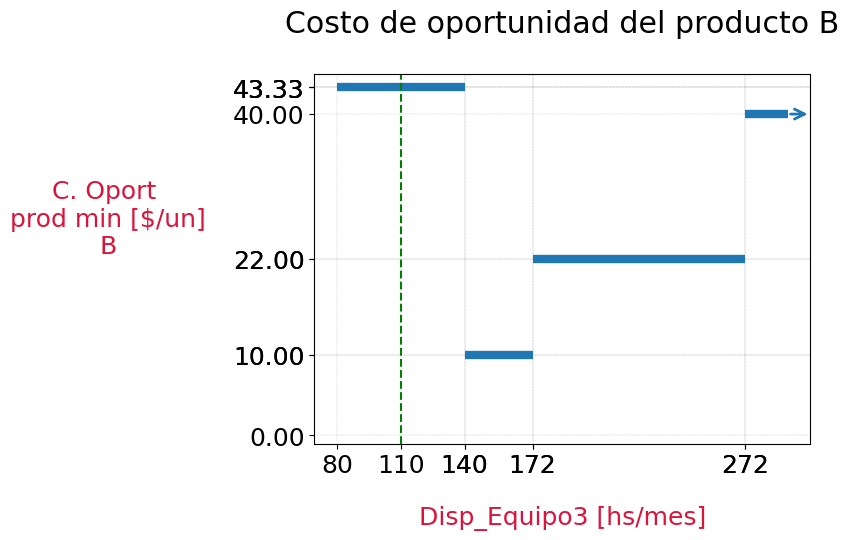

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Graficamos
plot_text = get_text_for_plot(constraint_nameX, product_name, "[hs/mes]", "[$/un]")
plot(rhs_values, dual_values, current_rhs_value, plot_text)